In [1]:
import os, glob, re
import shutil
import random
import json
import pyarrow.parquet as pq
import numpy as np
import h5py
import math
import time
from tqdm import tqdm
from multiprocessing import Pool

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])
minimum_nonzero_pixels = 3

def estimate_population_parameters(all_sample_sizes, all_sample_means, all_sample_stds):
    population_means = []
    population_stds = []
    for j in range(len(all_sample_means)):
        sample_means = all_sample_means[j]
        sample_stds = all_sample_stds[j]
        sample_sizes = all_sample_sizes[j]
        sample_means = sample_means[sample_sizes != 0]
        sample_stds = sample_stds[sample_sizes != 0]
        sample_sizes = sample_sizes[sample_sizes != 0]
        weighted_sum_of_variances = sum((n - 1) * s**2 for n, s in zip(sample_sizes, sample_stds))
        total_degrees_of_freedom = sum(n - 1 for n in sample_sizes)
        combined_variance = weighted_sum_of_variances / total_degrees_of_freedom
        population_std = np.sqrt(combined_variance)
        weighted_sum_of_means = sum(n * mean for n, mean in zip(sample_sizes, sample_means))
        total_observations = sum(sample_sizes)
        population_mean = weighted_sum_of_means / total_observations
        population_stds.append(population_std)
        population_means.append(population_mean)

    return population_means, population_stds

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [int(c) if c.isdigit() else c for c in re.split('([0-9]+)',s)]

### Calculate combined mean and std for original data

In [6]:
def combined_mean_std(size, mean, std):
    mean_ = np.dot(size, mean)/np.sum(size)
    std_ = np.sqrt((np.dot((np.array(size)-1), np.square(std)) + np.dot(size,np.square(mean-mean_)))/(np.sum(size)-1))
    return mean_, std_

# mean_ = []
# std_ = []
# size_ = []
# file_path = glob.glob("mean_std_record_original_dataset/*")
# for file in file_path:
#     with open(file, 'r') as file:
#         data = json.load(file)
#     mean_.append(data['original_mean'])
#     std_.append(data['original_std'])
#     size_.append(data['number_of_jets'])
# mean = np.array(mean_)
# std = np.array(std_)
# size = np.array(size_)


# orig_mean, orig_std = combined_mean_std(size, mean, std)
# print("original mean  :" , orig_mean,"\n")
# print("original std  :" , orig_std,"\n")

In [2]:
orig_mean  = np.array([ 1.98238779, -0.91442459,  0.41702185,  0.43513746,  0.02550795,  1.03056945,
  1.02679871,  1.03097381,  1.03844133,  1.62629969,  1.68150326,  1.6804281,  1.68519913])

orig_std  = np.array([1.59927372e+02, 2.85947917e+02, 2.79158669e+01, 2.07958307e+00,
 8.02803456e-02, 1.82661113e-01, 1.69144079e-01, 1.82877885e-01,
 2.07325503e-01, 9.95635565e-01, 1.09017288e+00, 1.07802983e+00, 1.12664552e+00]) 

### Mean and std after removel of outliers

In [3]:

def mean_std_after_outlier(file="/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_0000_train.h5",outdir = "mean_std_record_after_outlier", batch_size=7000, minimum_nonzero_pixels=3):
    print(f"processing file ---> {file}\n")
    tag = file.split('tauDR0p4')[-1].split('.')[0]
    data = h5py.File(file, 'r')
    num_images = data["all_jet"].shape[0]
    print(f"data size: {num_images}\n")
    size_ = []
    mean_ = []
    std_ = []
   

    for start_idx in tqdm(range(0, num_images, batch_size)):
        end_idx = min(start_idx + batch_size, num_images)
        images_batch = data["all_jet"][start_idx:end_idx, :, :, :]
        # print("start_idx : ", start_idx)
        # print("end_idx : ", end_idx)
        # print("images_batch before :",images_batch.shape)
        images_batch[np.abs(images_batch) < 1.e-5] = 0
        non_zero_mask = images_batch != 0
        # print("non_zero_mask", non_zero_mask)
        images_non_zero = np.where(non_zero_mask, images_batch, np.nan)
        size_channel = np.count_nonzero(non_zero_mask, axis=(2, 3))
        mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
        std_channel = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
        non_empty_event = np.all(size_channel > minimum_nonzero_pixels, axis=1)
        mean_channel = mean_channel[non_empty_event]
        std_channel = std_channel[non_empty_event]
        size_channel = size_channel[non_empty_event]
        # print("mean_channel   :", mean_channel.shape)
       
        # print("orig_mean   :", orig_mean.shape)
        # non_outlier_event = np.all(size_channel > 1 and mean_channel < (np.tile(orig_mean, (batch_size, 1)) + 10 * np.tile(orig_std, (batch_size, 1))), axis=1)
        non_outlier_event = np.all(np.logical_and(size_channel > 1, mean_channel < (orig_mean + 10 * orig_std)), axis=1)
        size_channel = size_channel[non_outlier_event]
        mean_channel = mean_channel[non_outlier_event]
        std_channel = std_channel[non_outlier_event]
        # print("size_channel  after :", size_channel.shape)
        size_.append(size_channel)
        mean_.append(mean_channel)
        std_.append(std_channel)

    data.close()  
    size_ = np.concatenate(size_, axis=0).T
    mean_ = np.concatenate(mean_, axis=0).T
    std_ = np.concatenate(std_, axis=0).T
    after_outlier_mean, after_outlier_std = estimate_population_parameters(size_, mean_, std_)

    print(f'Means with out outliers: {after_outlier_mean}\n' )
    print(f'Stds with out outliers : { after_outlier_std}\n')
    print(f'number_of_selected_jets_std : {std_.shape[1]}\n')
   

    stat = {
            "after_outlier_mean":after_outlier_mean,
            "after_outlier_std":after_outlier_std,
            "number_of_selected_jets":std_.shape[1]
            }

    if not os.path.exists(outdir):
        os.makedirs(outdir)

    with open(outdir +'/'+ f'after_outlier_mean_std_record_dataset{tag}.json', 'w') as fp:
        json.dump(stat, fp)
    
    return after_outlier_mean, after_outlier_std


### Calculatenumber of events after outlier

In [4]:

# def process_files(file):
#     file_path = file[0]
#     mean_std_after_outlier(file=file_path,outdir = "signal_mean_std_record_after_outlier", batch_size=5000, minimum_nonzero_pixels=3)
    
# file_list = np.sort(glob.glob("/pscratch/sd/b/bbbam/signal_hd5/*"))  
# args = list(zip(file_list)) 
# with Pool(len(file_list)) as p:
#     p.map(process_files,args)

processing file ---> /pscratch/sd/b/bbbam/signal_hd5/IMG_H_AATo4Tau_Hadronic_tauDR0p4_M10_signal_v2.h5
processing file ---> /pscratch/sd/b/bbbam/signal_hd5/IMG_H_AATo4Tau_Hadronic_tauDR0p4_M14_signal_v2.h5
processing file ---> /pscratch/sd/b/bbbam/signal_hd5/IMG_H_AATo4Tau_Hadronic_tauDR0p4_M4_signal_v2_1.h5
processing file ---> /pscratch/sd/b/bbbam/signal_hd5/IMG_H_AATo4Tau_Hadronic_tauDR0p4_M3p7_signal_v2_1.h5
processing file ---> /pscratch/sd/b/bbbam/signal_hd5/IMG_H_AATo4Tau_Hadronic_tauDR0p4_M8_signal_v2.h5
processing file ---> /pscratch/sd/b/bbbam/signal_hd5/IMG_H_AATo4Tau_Hadronic_tauDR0p4_M5_signal_v2_1.h5
processing file ---> /pscratch/sd/b/bbbam/signal_hd5/IMG_H_AATo4Tau_Hadronic_tauDR0p4_M6_signal_v2.h5
processing file ---> /pscratch/sd/b/bbbam/signal_hd5/IMG_H_AATo4Tau_Hadronic_tauDR0p4_M12_signal_v2.h5








data size: 279331
data size: 708412
data size: 544426
data size: 677934
data size: 24718
data size: 792604

data size: 65255
data size: 519319









  0%|          | 0/104 [00:00<?, ?it/s]/tmp/ipykernel_738769/3837311130.py:23: RuntimeWarning: Mean of empty slice
  mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
/tmp/ipykernel_738769/3837311130.py:23: RuntimeWarning: Mean of empty slice
  mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
/tmp/ipykernel_738769/3837311130.py:23: RuntimeWarning: Mean of empty slice
  mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
/tmp/ipykernel_738769/3837311130.py:23: RuntimeWarning: Mean of empty slice
  mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  7%|▋         | 1/14 [00:22<04:58, 22.92s/it]/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/numpy/lib/nanfunctions.p

Means with out outliers: [2.6865608799210396, -2.497004794676887, 0.5699339238488053, 0.47953034016002166, 0.03293167060626608, 1.0268524087892124, 1.0278992301151733, 1.0323643754363574, 1.039711456264997, 1.6545533853888337, 1.7043733616951435, 1.7012020758375552, 1.7045049449455807]

Stds with out outliers : [10.97781061520128, 397.0148910026761, 45.544589607910225, 2.600165867754024, 0.13679987684293693, 0.17012960767300014, 0.17256088238081815, 0.18713863350941395, 0.21189852373591825, 1.0205975480223382, 1.110588681128194, 1.0965528886796663, 1.1423760384488897]

number_of_selected_jets_std : 24689



100%|██████████| 14/14 [04:35<00:00, 19.67s/it]t]


Means with out outliers: [2.1651435868036493, -2.5826188372626873, 0.5004377030627525, 0.41678756747385104, 0.028163525304897363, 1.0272799958877703, 1.0275738818320026, 1.0319111705366313, 1.039243786934362, 1.6500129622079829, 1.702692883309105, 1.697398221890021, 1.7004411895934834]

Stds with out outliers : [14.505208906326647, 398.319590220976, 45.23922109167248, 2.130698742191357, 0.10328907229823991, 0.17161662554519055, 0.17139691527814307, 0.1858085304753394, 0.2096017912873865, 1.01572718515803, 1.1085311893073622, 1.0914675417709243, 1.1388991941724311]

number_of_selected_jets_std : 65014



 30%|███       | 48/159 [26:34<1:04:00, 34.60s/it]

Means with out outliers: [1.746095120385891, -1.8887735664404808, 0.5317110239754574, 0.3469911016028391, 0.024467054444567034, 1.0278716920607247, 1.0274415288047694, 1.031657400693812, 1.0389949734256139, 1.649964423076835, 1.7019662457560853, 1.6962808249914534, 1.6993566187588827]

Stds with out outliers : [10.044654149834882, 395.0797226412362, 42.8399261970657, 1.5330013811336538, 0.06705070372790087, 0.17367181633812678, 0.17072544628146982, 0.18458926777351553, 0.20860312894339836, 1.015204252912597, 1.1073406302953372, 1.0906183633444144, 1.1383875615808845]

number_of_selected_jets_std : 277160



 59%|█████▉    | 94/159 [51:32<32:46, 30.26s/it]]

Means with out outliers: [1.6909703645839802, -2.038535410168825, 0.5161994579272619, 0.3357711229135689, 0.023953289323407338, 1.0277363664999342, 1.0273715814785163, 1.031629666534759, 1.0390506104818706, 1.651569531539747, 1.7031600273940033, 1.6972352849667494, 1.6998721423979433]

Stds with out outliers : [18.368079196385416, 394.6994200230633, 43.36152219589373, 1.395735495668634, 0.06018474476715217, 0.17331461863508058, 0.17044116489951947, 0.1845184492244218, 0.2087724397840853, 1.0168427846751695, 1.108191744292038, 1.091348272617356, 1.1385403672621182]

number_of_selected_jets_std : 539654



 88%|████████▊ | 125/142 [1:05:04<08:27, 29.85s/it]

Means with out outliers: [1.6522022551998532, -2.5047643951042624, 0.5354048775791131, 0.33153548084428575, 0.023713661129287376, 1.0278760582712312, 1.0273834497358139, 1.0316504134556086, 1.0390118020115353, 1.6528570955855104, 1.704218608627377, 1.6980046229486723, 1.7006581889339776]

Stds with out outliers : [12.479374445312713, 395.7427530365259, 43.55615846557844, 1.3074930472637387, 0.05662138927481588, 0.17370669634371316, 0.1704617167762622, 0.1844931337989401, 0.20868306630718744, 1.018072773661839, 1.1092565145247872, 1.0920203643772313, 1.1392747908326126]

number_of_selected_jets_std : 514585



 80%|███████▉  | 127/159 [1:09:28<17:47, 33.36s/it]

Means with out outliers: [1.6398553527223527, -1.5459072909488698, 0.5360614093979064, 0.32828833173624633, 0.023531513844461883, 1.0276975124076881, 1.027411114408539, 1.0317008705566715, 1.03909070541507, 1.652465306905258, 1.703784131661638, 1.6979326357217681, 1.7005581391577866]

Stds with out outliers : [17.102175420750996, 395.68705712730764, 43.01158185277691, 1.2352373843854008, 0.053623514582647004, 0.1731718991978875, 0.17062008968540532, 0.18472069914382303, 0.20891962306852932, 1.017651192176635, 1.108843185448037, 1.0919951435280866, 1.1391813393722259]

number_of_selected_jets_std : 671929



 85%|████████▍ | 135/159 [1:13:38<12:29, 31.23s/it]

Means with out outliers: [1.6397306516665509, -2.5620126118046027, 0.521069695218393, 0.32781385353941206, 0.023529448314767446, 1.027795392660564, 1.0274899580689978, 1.0317185970426148, 1.0391151378883967, 1.652817723045712, 1.7043191935992958, 1.6980287660371505, 1.7009125500305016]

Stds with out outliers : [20.701488032203258, 395.75469732897307, 43.98707293005572, 1.2113679627338279, 0.052921877538200095, 0.17350704021753752, 0.1708453258061377, 0.18475326111160453, 0.20889154051664127, 1.0180008576706423, 1.1095825745418875, 1.0920979884513142, 1.1394933822398292]

number_of_selected_jets_std : 702444



100%|██████████| 159/159 [1:26:03<00:00, 32.47s/it]


Means with out outliers: [1.6755703385317502, -1.727007128920175, 0.5262959400895288, 0.3348491110107521, 0.023861970012413112, 1.0276890821138092, 1.0273999469449415, 1.0316303060257206, 1.0390182907085412, 1.6523573099688085, 1.70373602150417, 1.697803799498373, 1.7005002796700868]

Stds with out outliers : [18.64203691263941, 394.8348242618897, 43.21281431823621, 1.366553596908107, 0.0591930342377489, 0.17311778533757147, 0.17046963862349976, 0.184442906656135, 0.20868552945708002, 1.0174366534998076, 1.108748492321268, 1.0917407373406098, 1.1390940667659935]

number_of_selected_jets_std : 785398



### Calculate the comined mean and std of samples after removed outliers as well as original

In [7]:

mean_ = []
std_ = []
size_ = []
file_path = np.sort(glob.glob("mean_std_record_after_outlier/*"))
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['after_outlier_mean'])
    std_.append(data['after_outlier_std'])
    size_.append(data['number_of_selected_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)


after_outlier_mean, after_outlier_std = combined_mean_std(size, mean, std)
print("after outlier mean  : " , after_outlier_mean,"\n")
print("after outlier std  : " , after_outlier_std,"\n")
print("total selected jets : " , size, "\n")



mean_ = []
std_ = []
size_ = []
file_path = np.sort(glob.glob("signal_mean_std_record_after_outlier/*"))
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['after_outlier_mean'])
    std_.append(data['after_outlier_std'])
    size_.append(data['number_of_selected_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)


signal_after_outlier_mean, signal_after_outlier_std = combined_mean_std(size, mean, std)
print("signal after outlier mean  : " , after_outlier_mean,"\n")
print("signal after outlier std  : " , after_outlier_std,"\n")
print("total selected jets : " , size, "\n")


after outlier mean  :  [ 1.95973739 -0.91428634  0.41695268  0.4351373   0.02550794  1.03056946
  1.02679871  1.03097382  1.03844135  1.62629992  1.6815035   1.68042818
  1.68519924] 

after outlier std  :  [2.64603079e+01 2.85947850e+02 2.78975093e+01 2.07958377e+00
 8.02803342e-02 1.82661149e-01 1.69144090e-01 1.82877912e-01
 2.07325558e-01 9.95635728e-01 1.09017309e+00 1.07802985e+00
 1.12664562e+00] 

total selected jets :  [426826 416817 425975 416835 416735 425962 435157 416918 416843 428532] 

signal after outlier mean  :  [ 1.95973739 -0.91428634  0.41695268  0.4351373   0.02550794  1.03056946
  1.02679871  1.03097382  1.03844135  1.62629992  1.6815035   1.68042818
  1.68519924] 

signal after outlier std  :  [2.64603079e+01 2.85947850e+02 2.78975093e+01 2.07958377e+00
 8.02803342e-02 1.82661149e-01 1.69144090e-01 1.82877912e-01
 2.07325558e-01 9.95635728e-01 1.09017309e+00 1.07802985e+00
 1.12664562e+00] 

total selected jets :  [277160  65014  24689 702444 671929 514585 78539

In [8]:
### Number of outlier in each data set 
print("Nmmber of selected jets :", size)
print("Nmmber of outlier in dataset :", orig_size - size)
print("Total : ",np.sum(orig_size) ,"Total number of outliers : ", np.sum(orig_size - size), "outlier : " ,np.sum(orig_size - size)/np.sum(orig_size),"%")

Nmmber of selected jets : [277160  65014  24689 702444 671929 514585 785398 539654]


NameError: name 'orig_size' is not defined

### Convert h5 file to normalized signal h5

In [4]:
# file_list = glob.glob("/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/*")
# file_list

In [13]:
def h5_h5_normalizes(file_):
    
    
    file = file_
    data = h5py.File(f'{file}', 'r')
    num_images = data["all_jet"].shape[0]
    # num_images = 3500
    batch_size = 3200
    print(f"processing file ---> {file}\n")
    tag = file.split('tauDR0p4')[-1].split('.')[0]

    with open(f'signal_mean_std_record_after_outlier/after_outlier_mean_std_record_dataset{tag}.json', 'r') as file:
        data_ = json.load(file)
        size=data_['number_of_selected_jets']
    print("size : ", size,'\n') 
    outdir = '/pscratch/sd/b/bbbam/signal_normalized_h5'
    outdir_record = 'signal_mean_std_record_of_normalised_dataset_test'
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    outfile = f'signal_{tag}_normalized.h5'

    with h5py.File(f'{outdir}/{outfile}', 'w') as proper_data:
        dataset_names = ['all_jet', 'am', 'ieta', 'iphi', 'm0']
        datasets = {
            name: proper_data.create_dataset(
                name,
                (size,13, 125, 125) if 'jet' in name else (size, 1),
                dtype='float32',  # Specify an appropriate data type
                compression='lzf',
                chunks=(batch_size, 13, 125, 125) if 'jet' in name else (1, 1),
            ) for name in dataset_names
        }
        size_ = []
        mean_ = []
        std_ = []
        start_idx_, end_idx_ = 0, 0
        for start_idx in tqdm(range(0, num_images, batch_size)):
            end_idx = min(start_idx + batch_size, num_images)
            images_batch = data["all_jet"][start_idx:end_idx, :, :, :]
            am_batch = data["am"][start_idx:end_idx, :]
            ieta_batch = data["ieta"][start_idx:end_idx, :]
            iphi_batch = data["iphi"][start_idx:end_idx, :]
            m0_batch = data["m0"][start_idx:end_idx, :]
            images_batch[np.abs(images_batch) < 1.e-5] = 0
            non_zero_mask = images_batch != 0
            # print("non_zero_mask.shape  : ", non_zero_mask.shape) 
            images_non_zero = np.where(non_zero_mask, images_batch, np.nan)
            size_channel = np.count_nonzero(non_zero_mask, axis=(2, 3))
            mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
            std_channel = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
            non_empty_event = np.all(size_channel > minimum_nonzero_pixels, axis=1)
            mean_channel = mean_channel[non_empty_event]
            std_channel = std_channel[non_empty_event]
            size_channel = size_channel[non_empty_event]
            am_batch = am_batch[non_empty_event]
            ieta_batch = ieta_batch[non_empty_event]
            iphi_batch = iphi_batch[non_empty_event]
            m0_batch = m0_batch[non_empty_event]


            # print("images_non_zero.shape before : ", images_non_zero.shape)
            # print("size_channel.shape. ",size_channel.shape)
            # print("mean_channel.shape. ",mean_channel.shape)
            # print("orig_mean.shape.  ", orig_mean.shape)
            non_outlier_event = np.all(np.logical_and(size_channel > 1, mean_channel < (orig_mean + 10 * orig_std)), axis=1)

            # print("non_outlier_event.shape : ", non_outlier_event.shape)
            # print("non_outlier_event : ", non_outlier_event)

            images_non_zero = images_non_zero[non_empty_event]

            images_non_zero = images_non_zero[non_outlier_event]
            am_batch = am_batch[non_outlier_event]
            ieta_batch = ieta_batch[non_outlier_event]
            iphi_batch = iphi_batch[non_outlier_event]
            m0_batch = m0_batch[non_outlier_event]


            mean_channel = mean_channel[non_outlier_event]
            std_channel = std_channel[non_outlier_event]
            size_channel = size_channel[non_outlier_event]

            images_non_zero[np.isnan(images_non_zero)] = 0
            images_non_zero = (images_non_zero - after_outlier_mean.reshape(1, 13, 1, 1)) / after_outlier_std.reshape(1, 13, 1, 1)
            # print("images_non_zero.shape after : ", images_non_zero.shape)
            mean_channel_ = np.nanmean(images_non_zero, axis=(2, 3))
            std_channel_ = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
            size_.append(size_channel)
            mean_.append(mean_channel_)
            std_.append(std_channel_)
            start_idx_ = min(start_idx, end_idx_)
            end_idx_   = min(start_idx_ + images_non_zero.shape[0], num_images)
            # print("images_non_zero.shape ", images_non_zero.shape[0])


            proper_data['all_jet'][start_idx_:end_idx_,:,:,:] = images_non_zero
            proper_data['am'][start_idx_:end_idx_] = am_batch
            proper_data['ieta'][start_idx_:end_idx_] = ieta_batch
            proper_data['iphi'][start_idx_:end_idx_] = iphi_batch
            proper_data['m0'][start_idx_:end_idx_] = m0_batch
            # print("_____________________________________________________________")

    data.close()
    size_ = np.concatenate(size_, axis=0).T
    mean_ = np.concatenate(mean_, axis=0).T
    std_ = np.concatenate(std_, axis=0).T
    normalised_mean, normalised_std = estimate_population_parameters(size_, mean_, std_)

    print(f'Normalised mean: {normalised_mean}\n' )
    print(f'normalised std : {normalised_std}\n')
    print(f'number_of_selected_jets_std : {std_.shape[1]}\n')

    stat = {
            "normalised_mean":normalised_mean,
            "normalised_std":normalised_std,
            "number_of_selected_jets":std_.shape[1]
            }

    if not os.path.exists(outdir_record):
        os.makedirs(outdir_record)

    with open(outdir_record +'/'+ f'signal_normalised_mean_std_record_dataset_{tag}.json', 'w') as fp:
        json.dump(stat, fp)

    return normalised_mean, normalised_std


In [ ]:
# ### Run only once to convert h5 to nomalized h5
def process_files(file):
    file_path = file[0]
    h5_h5_normalizes(file_path)
    
file_list = np.sort(glob.glob("/pscratch/sd/b/bbbam/signal_hd5/*"))  
args = list(zip(file_list)) 
with Pool(10) as p:
    p.map(process_files,args)

processing file ---> /pscratch/sd/b/bbbam/signal_hd5/IMG_H_AATo4Tau_Hadronic_tauDR0p4_M10_signal_v2.h5
processing file ---> /pscratch/sd/b/bbbam/signal_hd5/IMG_H_AATo4Tau_Hadronic_tauDR0p4_M8_signal_v2.h5
processing file ---> /pscratch/sd/b/bbbam/signal_hd5/IMG_H_AATo4Tau_Hadronic_tauDR0p4_M6_signal_v2.h5
processing file ---> /pscratch/sd/b/bbbam/signal_hd5/IMG_H_AATo4Tau_Hadronic_tauDR0p4_M4_signal_v2_1.h5
processing file ---> /pscratch/sd/b/bbbam/signal_hd5/IMG_H_AATo4Tau_Hadronic_tauDR0p4_M3p7_signal_v2_1.h5
processing file ---> /pscratch/sd/b/bbbam/signal_hd5/IMG_H_AATo4Tau_Hadronic_tauDR0p4_M5_signal_v2_1.h5






size : size : size : size : size : size :       277160785398539654671929702444514585      













  0%|          | 0/163 [00:00<?, ?it/s]

processing file ---> /pscratch/sd/b/bbbam/signal_hd5/IMG_H_AATo4Tau_Hadronic_tauDR0p4_M12_signal_v2.h5
processing file ---> /pscratch/sd/b/bbbam/signal_hd5/IMG_H_AATo4Tau_Hadronic_tauDR0p4_M14_signal_v2.h5




  0%|          | 0/88 [00:00<?, ?it/s]

size :  65014size :  
 
24689 



  0%|          | 0/8 [00:00<?, ?it/s]]/tmp/ipykernel_738769/4263563174.py:49: RuntimeWarning: Mean of empty slice
  mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
/tmp/ipykernel_738769/4263563174.py:49: RuntimeWarning: Mean of empty slice
  mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_738769/4263563174.py:49: RuntimeWarning: Mean of empty slice
  mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
/tmp/ipykernel_738769/4263563174.py:49: RuntimeWarning: Mean

Normalised mean: [-0.07366293588747297, 0.0031742404383797995, -0.014857792803481512, -0.2054325608795544, -0.16470930144956902, -5.573117932755426, -5.979758330204716, -5.548551683396861, -4.931983422218918, -1.5703232367605862, -1.486307270587947, -1.4982738586656836, -1.4434671328180781]

normalised std : [0.027707439197726082, 0.10509120859941734, 0.10811153451583866, 0.16723651813156357, 1.064752111235118, 0.6301413130624356, 0.748168354604974, 0.7147860831997042, 0.6287791903482974, 0.3798906905533049, 0.35310296157778537, 0.3663523208452738, 0.33765206747689586]

number_of_selected_jets_std : 24689



100%|██████████| 21/21 [08:37<00:00, 24.65s/it]it]


Normalised mean: [-0.07374298232816413, 0.003163438301460545, -0.014870797282338921, -0.20636647284721604, -0.18707853535234772, -5.572944192271191, -5.980220069746025, -5.549051377542563, -4.932555219647387, -1.570650194576375, -1.4866239467063014, -1.4989187507947266, -1.4440104773533526]

normalised std : [0.03231924680071329, 0.10476058901660772, 0.10775326981415005, 0.13329334696267986, 0.8065950779405255, 0.6313255748366111, 0.7461338223424839, 0.7125521834148477, 0.626144138500746, 0.3782949568714179, 0.351905324095344, 0.3638284617943755, 0.3354884923856583]

number_of_selected_jets_std : 65014



 39%|███▊      | 63/163 [43:15<1:09:01, 41.41s/it]

### Combined mean and std of normalized h5

In [32]:
def combined_mean_std(size, mean, std):
    mean_ = np.dot(size, mean)/np.sum(size)
    std_ = np.sqrt((np.dot((np.array(size)-1), np.square(std)) + np.dot(size,np.square(mean-mean_)))/(np.sum(size)-1))
    return mean_, std_

mean_ = []
std_ = []
size_ = []
file_path = glob.glob("mean_std_record_of_normalised_dataset/*")
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['normalised_mean'])
    std_.append(data['normalised_std'])
    size_.append(data['number_of_selected_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)


orig_mean, orig_std = combined_mean_std(size, mean, std)
print("normalized mean  :" , orig_mean,"\n")
print("normalized std  :" , orig_std,"\n")
print("normalized samples  :" , size,"\n")


normalized mean  : [-5.77166362e-12  2.66629026e-11 -2.50583653e-12  4.40955855e-12
 -1.03461485e-11 -2.81219483e-09 -3.24569833e-11  2.62512279e-09
  4.16400841e-09  1.15795580e-10  1.08358136e-10  1.09066130e-10
  9.83479047e-11] 

normalized std  : [1.00000001 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ] 

normalized samples  : [416843 416817 428532 416835 426826 435157 425962 416735 416918 425975] 



## For massregression data m=1.2-3.6GeV and m=14.8-17.2 GeV pseudoscalar mass


### First calculate number of event passed to outlier cut , here only final count needed

In [4]:
def combined_mean_std(size, mean, std):
    mean_ = np.dot(size, mean)/np.sum(size)
    std_ = np.sqrt((np.dot((np.array(size)-1), np.square(std)) + np.dot(size,np.square(mean-mean_)))/(np.sum(size)-1))
    return mean_, std_

mean_ = []
std_ = []
size_ = []
file_path = np.sort(glob.glob("mean_std_record_original_dataset/*"))
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['original_mean'])
    std_.append(data['original_std'])
    size_.append(data['number_of_jets'])
mean = np.array(mean_)
std = np.array(std_)
orign_size = np.array(size_)


orig_mean, orig_std = combined_mean_std(orign_size, mean, std)
print("original mean  :" , orig_mean,"\n")
print("original std  :" , orig_std,"\n")
print("totoal samples  :" , orign_size,"\n")


### Calculate combined mean and std for data after outlier Run this before sonverting to normalised h5-----------------------------------------------------------------------------------------------------------



mean_ = []
std_ = []
size_ = []
file_path = np.sort(glob.glob("mean_std_record_after_outlier/*"))
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['after_outlier_mean'])
    std_.append(data['after_outlier_std'])
    size_.append(data['number_of_selected_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)


after_outlier_mean, after_outlier_std = combined_mean_std(size, mean, std)
print("after outlier mean  : " , after_outlier_mean,"\n")
print("after outlier std  : " , after_outlier_std,"\n")
print("total selected jets : " , size, "\n")

original mean  : [ 1.98238779 -0.91442459  0.41702185  0.43513746  0.02550795  1.03056945
  1.02679871  1.03097381  1.03844133  1.62629969  1.68150326  1.6804281
  1.68519913] 

original std  : [1.59927372e+02 2.85947917e+02 2.79158669e+01 2.07958307e+00
 8.02803456e-02 1.82661113e-01 1.69144079e-01 1.82877885e-01
 2.07325503e-01 9.95635565e-01 1.09017288e+00 1.07802983e+00
 1.12664552e+00] 

totoal samples  : [429739 419687 428952 419701 419665 428918 438180 419691 419703 431463] 

after outlier mean  :  [ 1.95973739 -0.91428634  0.41695268  0.4351373   0.02550794  1.03056946
  1.02679871  1.03097382  1.03844135  1.62629992  1.6815035   1.68042818
  1.68519924] 

after outlier std  :  [2.64603079e+01 2.85947850e+02 2.78975093e+01 2.07958377e+00
 8.02803342e-02 1.82661149e-01 1.69144090e-01 1.82877912e-01
 2.07325558e-01 9.95635728e-01 1.09017309e+00 1.07802985e+00
 1.12664562e+00] 

total selected jets :  [426826 416817 425975 416835 416735 425962 435157 416918 416843 428532] 



In [5]:
# orig_mean  =  np.array([1.96564565e+00, 2.08263890e+02, 5.58348869e+00, 4.31304512e-01,
#  2.56358780e-02, 1.03114537e+00, 1.02714137e+00, 1.03126102e+00,
#  1.03864744e+00, 1.63181412e+00, 1.68669425e+00, 1.68518954e+00,
#  1.68931466e+00]) 

# orig_std  =  np.array([1.64547331e+02, 2.40326927e+02, 3.08302240e+01, 2.06503512e+00,
#  8.01002674e-02, 1.84443168e-01, 1.70208005e-01, 1.83686938e-01,
#  2.07823703e-01, 1.00027121e+00, 1.09456862e+00, 1.08181558e+00,
#  1.12996825e+00]) 

# totoal_samples  =  np.array([419691, 419687, 438180, 419703, 419701, 429739, 431463, 428918, 419665, 428952]) 

# after_outlier_mean  =  np.array([1.94187487e+00, 2.08261770e+02, 5.58177329e+00, 4.31304269e-01,
#  2.56358990e-02, 1.03114542e+00, 1.02714137e+00, 1.03126105e+00,
#  1.03864745e+00, 1.63181452e+00, 1.68669463e+00, 1.68518982e+00,
#  1.68931468e+00]) 

# after_outlier_std  =  np.array([2.71139741e+01, 2.40285633e+02, 3.06056467e+01, 2.06503835e+00,
#  8.01002918e-02, 1.84443340e-01, 1.70208019e-01, 1.83687021e-01,
#  2.07823705e-01, 1.00027157e+00, 1.09456875e+00, 1.08181565e+00,
#  1.12996794e+00]) 

# after_outlier_selected_jets =  np.array([383216, 400368, 383230, 383125, 391450, 383631, 391998, 393935, 392235, 383309]) 



def mean_std_after_outlier(file="/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_0000_train.h5",outdir="number_of_event_passed_outlier_cut_m14p8To17p2", batch_size=20000, minimum_nonzero_pixels=3):
    print(f"processing file ---> {file}\n")
    tag = file.split('_')[-2]
    data = h5py.File(file, 'r')
    num_images = data["all_jet"].shape[0]
    print(f"data size: {num_images}\n")
    size_ = []
    mean_ = []
    std_ = []
   

    for start_idx in tqdm(range(0, num_images, batch_size)):
        end_idx = min(start_idx + batch_size, num_images)
        images_batch = data["all_jet"][start_idx:end_idx, :, :, :]
        # print("start_idx : ", start_idx)
        # print("end_idx : ", end_idx)
        # print("images_batch before :",images_batch.shape)
        images_batch[np.abs(images_batch) < 1.e-5] = 0
        non_zero_mask = images_batch != 0
        # print("non_zero_mask", non_zero_mask)
        images_non_zero = np.where(non_zero_mask, images_batch, np.nan)
        size_channel = np.count_nonzero(non_zero_mask, axis=(2, 3))
        mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
        std_channel = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
        non_empty_event = np.all(size_channel > minimum_nonzero_pixels, axis=1)
        mean_channel = mean_channel[non_empty_event]
        std_channel = std_channel[non_empty_event]
        size_channel = size_channel[non_empty_event]
        # print("mean_channel   :", mean_channel.shape)
       
        # print("orig_mean   :", orig_mean.shape)
        # non_outlier_event = np.all(size_channel > 1 and mean_channel < (np.tile(orig_mean, (batch_size, 1)) + 10 * np.tile(orig_std, (batch_size, 1))), axis=1)
        non_outlier_event = np.all(np.logical_and(size_channel > 1, mean_channel < (orig_mean + 10 * orig_std)), axis=1)
        size_channel = size_channel[non_outlier_event]
        mean_channel = mean_channel[non_outlier_event]
        std_channel = std_channel[non_outlier_event]
        # print("size_channel  after :", size_channel.shape)
        size_.append(size_channel)
        mean_.append(mean_channel)
        std_.append(std_channel)

    data.close()  
    size_ = np.concatenate(size_, axis=0).T
    mean_ = np.concatenate(mean_, axis=0).T
    std_ = np.concatenate(std_, axis=0).T
    after_outlier_mean, after_outlier_std = estimate_population_parameters(size_, mean_, std_)

    print(f'Means with out outliers: {after_outlier_mean}\n' )
    print(f'Stds with out outliers : { after_outlier_std}\n')
    print(f'number_of_selected_jets_std : {std_.shape[1]}\n')
   

    stat = {
            "after_outlier_mean":after_outlier_mean,
            "after_outlier_std":after_outlier_std,
            "number_of_selected_jets":std_.shape[1]
            }

    if not os.path.exists(outdir):
        os.makedirs(outdir)

    with open(outdir +'/'+ f'after_outlier_mean_std_record_dataset_{tag}.json', 'w') as fp:
        json.dump(stat, fp)
    
    return after_outlier_mean, after_outlier_std


In [12]:
# # # ### Run only once to calculate the mean and std after outlier removed
# def process_files(file):
#     file_path = file[0]
#     mean_std_after_outlier(file=file_path,outdir = "number_of_event_passed_outlier_cut_m1p2To3p6", batch_size=14000, minimum_nonzero_pixels=3)
    
# file_list = glob.glob("/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m14p8To17p2_dataset_2_unbaised_v2_train_hd5/*")
# # print(file_list)
# args = list(zip(file_list)) 
# with Pool(len(file_list)) as p:
#     p.map(process_files,args)


processing file ---> /pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m14p8To17p2_dataset_2_unbaised_v2_train_hd5/IMG_aToTauTau_Hadronic_tauDR0p4_m14To17p2_dataset_2_unbaised_0001_train.h5

data size: 71759



  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_27161/2747405248.py:49: RuntimeWarning: Mean of empty slice
  mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
100%|██████████| 6/6 [09:04<00:00, 90.77s/it] 


Means with out outliers: [2.0308102667634644, -0.5824509818457739, 0.4274414872459955, 0.43080606160519574, 0.026726402956675766, 1.0343065204235338, 1.0274876114395484, 1.0310824688754845, 1.0384829135131368, 1.6234570740333227, 1.6797149747533515, 1.6795547992984594, 1.684294865186919]

Stds with out outliers : [9.499739114606195, 296.6318680967386, 29.513548828707417, 2.1455932524425365, 0.08644971346164616, 0.19426618836055512, 0.1716216038444276, 0.18330061545437087, 0.20749196063379, 0.9931644151542468, 1.0881643792161835, 1.076568857590226, 1.125532246843051]

number_of_selected_jets_std : 71477



In [11]:
file_list = glob.glob("/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m14p8To17p2_dataset_2_unbaised_v2_train_hd5/IMG_aToTauTau_Hadronic_tauDR0p4_m14To17p2_dataset_2_unbaised_0001_train.h5")
file_list
# ! ls /pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m14p8To17p2_dataset_2_unbaised_v2_train_hd5

['/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m14p8To17p2_dataset_2_unbaised_v2_train_hd5/IMG_aToTauTau_Hadronic_tauDR0p4_m14To17p2_dataset_2_unbaised_0001_train.h5']

In [11]:
# # # ### Run only once to calculate the mean and std after outlier removed
# def process_files(file):
#     file_path = file[0]
#     mean_std_after_outlier(file=file_path,outdir = "number_of_event_passed_outlier_cut_m14p8To17p2", batch_size=14000, minimum_nonzero_pixels=3)
    
# file_list = glob.glob("/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m14p8To17p2_dataset_2_unbaised_v2_train_hd5/*")   
# # print(file_list)
# args = list(zip(file_list)) 
# with Pool(10) as p:
#     p.map(process_files,args)


### convert to normalised h5  M = 1.2-3.6 GeV

In [17]:
def combined_mean_std(size, mean, std):
    mean_ = np.dot(size, mean)/np.sum(size)
    std_ = np.sqrt((np.dot((np.array(size)-1), np.square(std)) + np.dot(size,np.square(mean-mean_)))/(np.sum(size)-1))
    return mean_, std_

mean_ = []
std_ = []
size_ = []
file_path = np.sort(glob.glob("mean_std_record_original_dataset/*"))
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['original_mean'])
    std_.append(data['original_std'])
    size_.append(data['number_of_jets'])
mean = np.array(mean_)
std = np.array(std_)
orign_size = np.array(size_)


orig_mean, orig_std = combined_mean_std(size, mean, std)
print("original mean  :" , orig_mean,"\n")
print("original std  :" , orig_std,"\n")
print("totoal samples  :" , orign_size,"\n")


### Calculate combined mean and std for data after outlier Run this before sonverting to normalised h5-----------------------------------------------------------------------------------------------------------



mean_ = []
std_ = []
size_ = []
file_path = np.sort(glob.glob("mean_std_record_after_outlier/*"))
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['after_outlier_mean'])
    std_.append(data['after_outlier_std'])
    size_.append(data['number_of_selected_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)


after_outlier_mean, after_outlier_std = combined_mean_std(size, mean, std)
print("after outlier mean  : " , after_outlier_mean,"\n")
print("after outlier std  : " , after_outlier_std,"\n")
print("total selected jets : " , size, "\n")

original mean  : [ 1.98238983 -0.91443455  0.4170219   0.43513744  0.02550795  1.03056945
  1.02679871  1.03097381  1.03844133  1.62629969  1.68150326  1.6804281
  1.68519913] 

original std  : [1.59939174e+02 2.85947912e+02 2.79158681e+01 2.07958280e+00
 8.02803519e-02 1.82661106e-01 1.69144078e-01 1.82877883e-01
 2.07325501e-01 9.95635558e-01 1.09017287e+00 1.07802982e+00
 1.12664550e+00] 

totoal samples  : [429739 419687 428952 419701 419665 428918 438180 419691 419703 431463] 

after outlier mean  :  [ 1.95973739 -0.91428634  0.41695268  0.4351373   0.02550794  1.03056946
  1.02679871  1.03097382  1.03844135  1.62629992  1.6815035   1.68042818
  1.68519924] 

after outlier std  :  [2.64603079e+01 2.85947850e+02 2.78975093e+01 2.07958377e+00
 8.02803342e-02 1.82661149e-01 1.69144090e-01 1.82877912e-01
 2.07325558e-01 9.95635728e-01 1.09017309e+00 1.07802985e+00
 1.12664562e+00] 

total selected jets :  [426826 416817 425975 416835 416735 425962 435157 416918 416843 428532] 



In [18]:
def h5_h5_normalizes(file_):
    
#     orig_mean  =  np.array([1.96564565e+00, 2.08263890e+02, 5.58348869e+00, 4.31304512e-01,
#      2.56358780e-02, 1.03114537e+00, 1.02714137e+00, 1.03126102e+00,
#      1.03864744e+00, 1.63181412e+00, 1.68669425e+00, 1.68518954e+00,
#      1.68931466e+00]) 

#     orig_std  =  np.array([1.64547331e+02, 2.40326927e+02, 3.08302240e+01, 2.06503512e+00,
#      8.01002674e-02, 1.84443168e-01, 1.70208005e-01, 1.83686938e-01,
#      2.07823703e-01, 1.00027121e+00, 1.09456862e+00, 1.08181558e+00,
#      1.12996825e+00]) 

    

#     after_outlier_mean  =  np.array([1.94187487e+00, 2.08261770e+02, 5.58177329e+00, 4.31304269e-01,
#      2.56358990e-02, 1.03114542e+00, 1.02714137e+00, 1.03126105e+00,
#      1.03864745e+00, 1.63181452e+00, 1.68669463e+00, 1.68518982e+00,
#      1.68931468e+00]) 

#     after_outlier_std  =  np.array([2.71139741e+01, 2.40285633e+02, 3.06056467e+01, 2.06503835e+00,
#      8.01002918e-02, 1.84443340e-01, 1.70208019e-01, 1.83687021e-01,
#      2.07823705e-01, 1.00027157e+00, 1.09456875e+00, 1.08181565e+00,
#      1.12996794e+00]) 

     
    
    file = file_
    data = h5py.File(f'{file}', 'r')
    num_images = data["all_jet"].shape[0]
    # num_images = 15000
    batch_size = 3200
    print(f"processing file ---> {file}\n")
    tag = file.split('_')[-2]

    with open(f'number_of_event_passed_outlier_cut_m1p2To3p6/after_outlier_mean_std_record_dataset_{tag}.json', 'r') as file:
        data_ = json.load(file)
        size=data_['number_of_selected_jets']
    print("size : ", size,'\n') 
    outdir = '/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m1p2To3p6_dataset_2_unbaised_v2_normalised_train_hd5'
    outdir_record = 'mean_std_record_of_normalised_dataset_m1p2To3p6'
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    outfile = f'IMG_aToTauTau_Hadronic_tauDR0p4_m1p2To3p6_dataset_2_unbaised_v2_{tag}_normalized_train.h5'

    with h5py.File(f'{outdir}/{outfile}', 'w') as proper_data:
        dataset_names = ['all_jet', 'am', 'ieta', 'iphi', 'm0']
        datasets = {
            name: proper_data.create_dataset(
                name,
                (size,13, 125, 125) if 'jet' in name else (size, 1),
                dtype='float32',  # Specify an appropriate data type
                compression='lzf',
                chunks=(batch_size, 13, 125, 125) if 'jet' in name else (1, 1),
            ) for name in dataset_names
        }
        size_ = []
        mean_ = []
        std_ = []
        start_idx_, end_idx_ = 0, 0
        for start_idx in tqdm(range(0, num_images, batch_size)):
            end_idx = min(start_idx + batch_size, num_images)
            images_batch = data["all_jet"][start_idx:end_idx, :, :, :]
            am_batch = data["am"][start_idx:end_idx, :]
            ieta_batch = data["ieta"][start_idx:end_idx, :]
            iphi_batch = data["iphi"][start_idx:end_idx, :]
            m0_batch = data["m0"][start_idx:end_idx, :]
            images_batch[np.abs(images_batch) < 1.e-5] = 0
            non_zero_mask = images_batch != 0
            # print("non_zero_mask.shape  : ", non_zero_mask.shape) 
            images_non_zero = np.where(non_zero_mask, images_batch, np.nan)
            size_channel = np.count_nonzero(non_zero_mask, axis=(2, 3))
            mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
            std_channel = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
            non_empty_event = np.all(size_channel > minimum_nonzero_pixels, axis=1)
            mean_channel = mean_channel[non_empty_event]
            std_channel = std_channel[non_empty_event]
            size_channel = size_channel[non_empty_event]
            am_batch = am_batch[non_empty_event]
            ieta_batch = ieta_batch[non_empty_event]
            iphi_batch = iphi_batch[non_empty_event]
            m0_batch = m0_batch[non_empty_event]


            # print("images_non_zero.shape before : ", images_non_zero.shape)
            # print("size_channel.shape. ",size_channel.shape)
            # print("mean_channel.shape. ",mean_channel.shape)
            # print("orig_mean.shape.  ", orig_mean.shape)
            non_outlier_event = np.all(np.logical_and(size_channel > 1, mean_channel < (orig_mean + 10 * orig_std)), axis=1)

            # print("non_outlier_event.shape : ", non_outlier_event.shape)
            # print("non_outlier_event : ", non_outlier_event)

            images_non_zero = images_non_zero[non_empty_event]

            images_non_zero = images_non_zero[non_outlier_event]
            am_batch = am_batch[non_outlier_event]
            ieta_batch = ieta_batch[non_outlier_event]
            iphi_batch = iphi_batch[non_outlier_event]
            m0_batch = m0_batch[non_outlier_event]


            mean_channel = mean_channel[non_outlier_event]
            std_channel = std_channel[non_outlier_event]
            size_channel = size_channel[non_outlier_event]

            images_non_zero[np.isnan(images_non_zero)] = 0
            images_non_zero = (images_non_zero - after_outlier_mean.reshape(1, 13, 1, 1)) / after_outlier_std.reshape(1, 13, 1, 1)
            # print("images_non_zero.shape after : ", images_non_zero.shape)
            mean_channel_ = np.nanmean(images_non_zero, axis=(2, 3))
            std_channel_ = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
            size_.append(size_channel)
            mean_.append(mean_channel_)
            std_.append(std_channel_)
            start_idx_ = min(start_idx, end_idx_)
            end_idx_   = min(start_idx_ + images_non_zero.shape[0], num_images)
            # print("images_non_zero.shape ", images_non_zero.shape[0])


            proper_data['all_jet'][start_idx_:end_idx_,:,:,:] = images_non_zero
            proper_data['am'][start_idx_:end_idx_] = am_batch
            proper_data['ieta'][start_idx_:end_idx_] = ieta_batch
            proper_data['iphi'][start_idx_:end_idx_] = iphi_batch
            proper_data['m0'][start_idx_:end_idx_] = m0_batch
            # print("_____________________________________________________________")

    data.close()
    size_ = np.concatenate(size_, axis=0).T
    mean_ = np.concatenate(mean_, axis=0).T
    std_ = np.concatenate(std_, axis=0).T
    normalised_mean, normalised_std = estimate_population_parameters(size_, mean_, std_)

    print(f'Normalised mean: {normalised_mean}\n' )
    print(f'normalised std : {normalised_std}\n')
    print(f'number_of_selected_jets_std : {std_.shape[1]}\n')

    stat = {
            "normalised_mean":normalised_mean,
            "normalised_std":normalised_std,
            "number_of_selected_jets":std_.shape[1]
            }

    if not os.path.exists(outdir_record):
        os.makedirs(outdir_record)

    with open(outdir_record +'/'+ f'normalised_mean_std_record_dataset_{tag}.json', 'w') as fp:
        json.dump(stat, fp)

    return normalised_mean, normalised_std


In [10]:

# # ### Run only once to convert h5 to nomalized h5
# def process_files(file):
#     file_path = file[0]
#     h5_h5_normalizes(file_path)
    
# file_list = glob.glob("/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m1p2To3p6_dataset_2_unbaised_v2_train_hd5/*")   
# args = list(zip(file_list)) 
# with Pool(10) as p:
#     p.map(process_files,args)

### convert to normalised h5  M = 1.4.8-17.2 GeV

In [13]:
def combined_mean_std(size, mean, std):
    mean_ = np.dot(size, mean)/np.sum(size)
    std_ = np.sqrt((np.dot((np.array(size)-1), np.square(std)) + np.dot(size,np.square(mean-mean_)))/(np.sum(size)-1))
    return mean_, std_

mean_ = []
std_ = []
size_ = []
file_path = np.sort(glob.glob("mean_std_record_original_dataset/*"))
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['original_mean'])
    std_.append(data['original_std'])
    size_.append(data['number_of_jets'])
mean = np.array(mean_)
std = np.array(std_)
orign_size = np.array(size_)


orig_mean, orig_std = combined_mean_std(size, mean, std)
print("original mean  :" , orig_mean,"\n")
print("original std  :" , orig_std,"\n")
print("totoal samples  :" , orign_size,"\n")


### Calculate combined mean and std for data after outlier Run this before sonverting to normalised h5-----------------------------------------------------------------------------------------------------------



mean_ = []
std_ = []
size_ = []
file_path = np.sort(glob.glob("mean_std_record_after_outlier/*"))
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['after_outlier_mean'])
    std_.append(data['after_outlier_std'])
    size_.append(data['number_of_selected_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)


after_outlier_mean, after_outlier_std = combined_mean_std(size, mean, std)
print("after outlier mean  : " , after_outlier_mean,"\n")
print("after outlier std  : " , after_outlier_std,"\n")
print("total selected jets : " , size, "\n")

original mean  : [ 1.98238983 -0.91443455  0.4170219   0.43513744  0.02550795  1.03056945
  1.02679871  1.03097381  1.03844133  1.62629969  1.68150326  1.6804281
  1.68519913] 

original std  : [1.59939174e+02 2.85947912e+02 2.79158681e+01 2.07958280e+00
 8.02803519e-02 1.82661106e-01 1.69144078e-01 1.82877883e-01
 2.07325501e-01 9.95635558e-01 1.09017287e+00 1.07802982e+00
 1.12664550e+00] 

totoal samples  : [429739 419687 428952 419701 419665 428918 438180 419691 419703 431463] 

after outlier mean  :  [ 1.95973739 -0.91428634  0.41695268  0.4351373   0.02550794  1.03056946
  1.02679871  1.03097382  1.03844135  1.62629992  1.6815035   1.68042818
  1.68519924] 

after outlier std  :  [2.64603079e+01 2.85947850e+02 2.78975093e+01 2.07958377e+00
 8.02803342e-02 1.82661149e-01 1.69144090e-01 1.82877912e-01
 2.07325558e-01 9.95635728e-01 1.09017309e+00 1.07802985e+00
 1.12664562e+00] 

total selected jets :  [426826 416817 425975 416835 416735 425962 435157 416918 416843 428532] 



In [14]:
def h5_h5_normalizes(file_):
    file = file_
    data = h5py.File(f'{file}', 'r')
    num_images = data["all_jet"].shape[0]
    # num_images = 15000
    batch_size = 3200
    print(f"processing file ---> {file}\n")
    tag = file.split('_')[-2]

    with open(f'number_of_event_passed_outlier_cut_m14p8To17p2/after_outlier_mean_std_record_dataset_{tag}.json', 'r') as file:
        data_ = json.load(file)
        size=data_['number_of_selected_jets']
    print("size : ", size,'\n') 
    outdir = '/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m14p8To17p2_dataset_2_unbaised_v2_normalised_train_hd5'
    outdir_record = 'mean_std_record_of_normalised_dataset_m14p8To17p2'
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    outfile = f'IMG_aToTauTau_Hadronic_tauDR0p4_m14p8To17p2_dataset_2_unbaised_v2_{tag}_normalized_train.h5'

    with h5py.File(f'{outdir}/{outfile}', 'w') as proper_data:
        dataset_names = ['all_jet', 'am', 'ieta', 'iphi', 'm0']
        datasets = {
            name: proper_data.create_dataset(
                name,
                (size,13, 125, 125) if 'jet' in name else (size, 1),
                dtype='float32',  # Specify an appropriate data type
                compression='lzf',
                chunks=(batch_size, 13, 125, 125) if 'jet' in name else (1, 1),
            ) for name in dataset_names
        }
        size_ = []
        mean_ = []
        std_ = []
        start_idx_, end_idx_ = 0, 0
        for start_idx in tqdm(range(0, num_images, batch_size)):
            end_idx = min(start_idx + batch_size, num_images)
            images_batch = data["all_jet"][start_idx:end_idx, :, :, :]
            am_batch = data["am"][start_idx:end_idx, :]
            ieta_batch = data["ieta"][start_idx:end_idx, :]
            iphi_batch = data["iphi"][start_idx:end_idx, :]
            m0_batch = data["m0"][start_idx:end_idx, :]
            images_batch[np.abs(images_batch) < 1.e-5] = 0
            non_zero_mask = images_batch != 0
            # print("non_zero_mask.shape  : ", non_zero_mask.shape) 
            images_non_zero = np.where(non_zero_mask, images_batch, np.nan)
            size_channel = np.count_nonzero(non_zero_mask, axis=(2, 3))
            mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
            std_channel = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
            non_empty_event = np.all(size_channel > minimum_nonzero_pixels, axis=1)
            mean_channel = mean_channel[non_empty_event]
            std_channel = std_channel[non_empty_event]
            size_channel = size_channel[non_empty_event]
            am_batch = am_batch[non_empty_event]
            ieta_batch = ieta_batch[non_empty_event]
            iphi_batch = iphi_batch[non_empty_event]
            m0_batch = m0_batch[non_empty_event]


            # print("images_non_zero.shape before : ", images_non_zero.shape)
            # print("size_channel.shape. ",size_channel.shape)
            # print("mean_channel.shape. ",mean_channel.shape)
            # print("orig_mean.shape.  ", orig_mean.shape)
            non_outlier_event = np.all(np.logical_and(size_channel > 1, mean_channel < (orig_mean + 10 * orig_std)), axis=1)

            # print("non_outlier_event.shape : ", non_outlier_event.shape)
            # print("non_outlier_event : ", non_outlier_event)

            images_non_zero = images_non_zero[non_empty_event]

            images_non_zero = images_non_zero[non_outlier_event]
            am_batch = am_batch[non_outlier_event]
            ieta_batch = ieta_batch[non_outlier_event]
            iphi_batch = iphi_batch[non_outlier_event]
            m0_batch = m0_batch[non_outlier_event]


            mean_channel = mean_channel[non_outlier_event]
            std_channel = std_channel[non_outlier_event]
            size_channel = size_channel[non_outlier_event]

            images_non_zero[np.isnan(images_non_zero)] = 0
            images_non_zero = (images_non_zero - after_outlier_mean.reshape(1, 13, 1, 1)) / after_outlier_std.reshape(1, 13, 1, 1)
            # print("images_non_zero.shape after : ", images_non_zero.shape)
            mean_channel_ = np.nanmean(images_non_zero, axis=(2, 3))
            std_channel_ = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
            size_.append(size_channel)
            mean_.append(mean_channel_)
            std_.append(std_channel_)
            start_idx_ = min(start_idx, end_idx_)
            end_idx_   = min(start_idx_ + images_non_zero.shape[0], num_images)
            # print("images_non_zero.shape ", images_non_zero.shape[0])


            proper_data['all_jet'][start_idx_:end_idx_,:,:,:] = images_non_zero
            proper_data['am'][start_idx_:end_idx_] = am_batch
            proper_data['ieta'][start_idx_:end_idx_] = ieta_batch
            proper_data['iphi'][start_idx_:end_idx_] = iphi_batch
            proper_data['m0'][start_idx_:end_idx_] = m0_batch
            # print("_____________________________________________________________")

    data.close()
    size_ = np.concatenate(size_, axis=0).T
    mean_ = np.concatenate(mean_, axis=0).T
    std_ = np.concatenate(std_, axis=0).T
    normalised_mean, normalised_std = estimate_population_parameters(size_, mean_, std_)

    print(f'Normalised mean: {normalised_mean}\n' )
    print(f'normalised std : {normalised_std}\n')
    print(f'number_of_selected_jets_std : {std_.shape[1]}\n')

    stat = {
            "normalised_mean":normalised_mean,
            "normalised_std":normalised_std,
            "number_of_selected_jets":std_.shape[1]
            }

    if not os.path.exists(outdir_record):
        os.makedirs(outdir_record)

    with open(outdir_record +'/'+ f'normalised_mean_std_record_dataset_{tag}.json', 'w') as fp:
        json.dump(stat, fp)

    return normalised_mean, normalised_std


In [16]:
# # ### Run only once to convert h5 to nomalized h5
# def process_files(file):
#     file_path = file[0]
#     h5_h5_normalizes(file_path)
    
# file_list = glob.glob("/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m14p8To17p2_dataset_2_unbaised_v2_train_hd5/*") 
# args = list(zip(file_list)) 
# with Pool(10) as p:
#     p.map(process_files,args)

#  Plots for man and std

In [39]:
def combined_mean_std(size, mean, std):
    mean_ = np.dot(size, mean)/np.sum(size)
    std_ = np.sqrt((np.dot((np.array(size)-1), np.square(std)) + np.dot(size,np.square(mean-mean_)))/(np.sum(size)-1))
    return mean_, std_

mean_ = []
std_ = []
size_ = []
file_path = glob.glob("mean_std_record_original_dataset/*")
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['original_mean'])
    std_.append(data['original_std'])
    size_.append(data['number_of_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)


orig_mean, orig_std = combined_mean_std(size, mean, std)
print("original mean  :" , orig_mean,"\n")
print("original std  :" , orig_std,"\n")
print("original number of jet. ", np.sum(size),'\n')

mean_ = []
std_ = []
size_ = []
file_path = glob.glob("mean_std_record_after_outlier/*")
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    # print(data.keys())
    mean_.append(data['after_outlier_mean'])
    std_.append(data['after_outlier_std'])
    size_.append(data['number_of_selected_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)

after_outlier_mean, after_outlier_std = combined_mean_std(size, mean, std)
print("after outlier mean  :" , after_outlier_mean,"\n")
print("after outlier std  :" , after_outlier_std,"\n")
print("after outlier cut number of jet. ", np.sum(size),'\n')

mean_ = []
std_ = []
size_ = []
file_path = glob.glob("mean_std_record_of_normalised_dataset/*")
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    # print(data.keys())
    mean_.append(data['normalised_mean'])
    std_.append(data['normalised_std'])
    size_.append(data['number_of_selected_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)

normalised_mean, normalised_std = combined_mean_std(size, mean, std)
print("normalised_mean  :" , normalised_mean,"\n")
print("normalised_std  :" , normalised_std,"\n")
print("normalised number of jet. ", np.sum(size),'\n')

original mean  : [1.96564565e+00 2.08263890e+02 5.58348869e+00 4.31304512e-01
 2.56358780e-02 1.03114537e+00 1.02714137e+00 1.03126102e+00
 1.03864744e+00 1.63181412e+00 1.68669425e+00 1.68518954e+00
 1.68931466e+00] 

original std  : [1.64547331e+02 2.40326927e+02 3.08302240e+01 2.06503512e+00
 8.01002674e-02 1.84443168e-01 1.70208005e-01 1.83686938e-01
 2.07823703e-01 1.00027121e+00 1.09456862e+00 1.08181558e+00
 1.12996825e+00] 

original number of jet.  4255699 

after outlier mean  : [1.94187487e+00 2.08261770e+02 5.58177329e+00 4.31304269e-01
 2.56358990e-02 1.03114542e+00 1.02714137e+00 1.03126105e+00
 1.03864745e+00 1.63181452e+00 1.68669463e+00 1.68518982e+00
 1.68931468e+00] 

after outlier std  : [2.71139741e+01 2.40285633e+02 3.06056467e+01 2.06503835e+00
 8.01002918e-02 1.84443340e-01 1.70208019e-01 1.83687021e-01
 2.07823705e-01 1.00027157e+00 1.09456875e+00 1.08181565e+00
 1.12996794e+00] 

after outlier cut number of jet.  3886497 

normalised_mean  : [-9.21945432e-11  

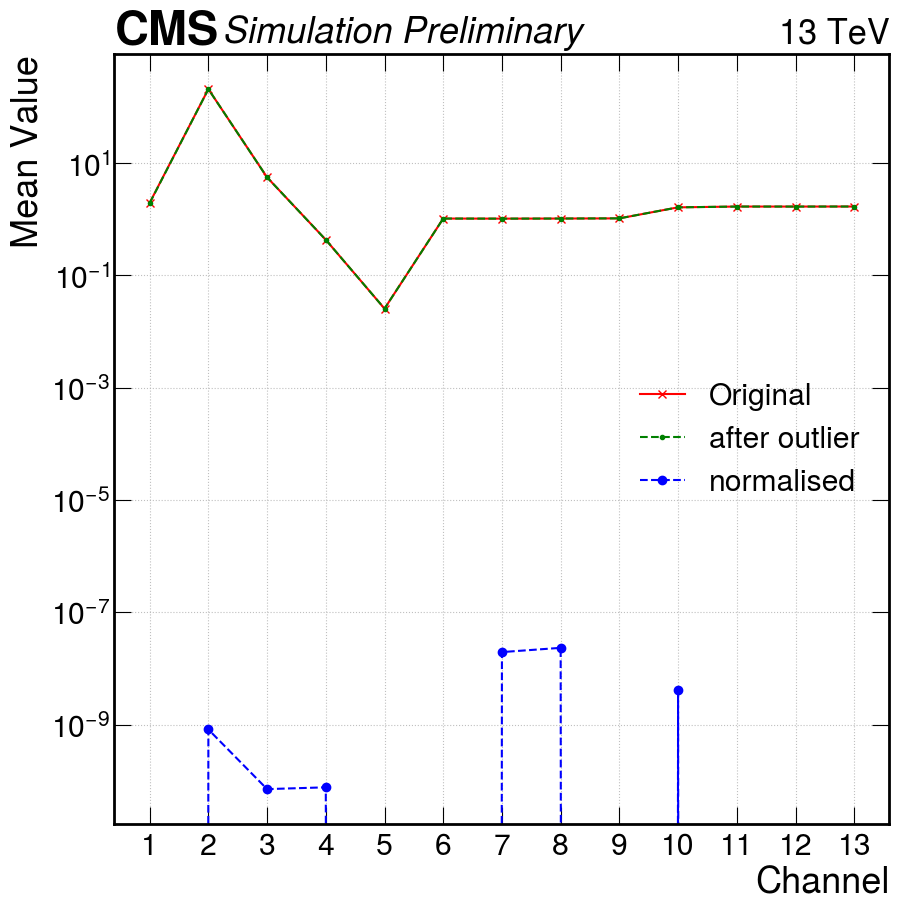

In [76]:

Channels = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# Plotting
fig, ax = plt.subplots()
plt.plot(Channels, orig_mean, marker='x',color = 'r',label='Original')
plt.plot(Channels, after_outlier_mean, marker='.', linestyle='--', color = 'g',label='after outlier')
plt.plot(Channels, normalised_mean, marker='o', linestyle='--', color = 'b',label='normalised')
plt.xlabel('Channel')
plt.xticks(np.arange(1, 14, 1))
plt.ylabel('Mean Value')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
plt.grid(True)
plt.minorticks_off()
plt.legend()
plt.yscale('log')
plt.show()


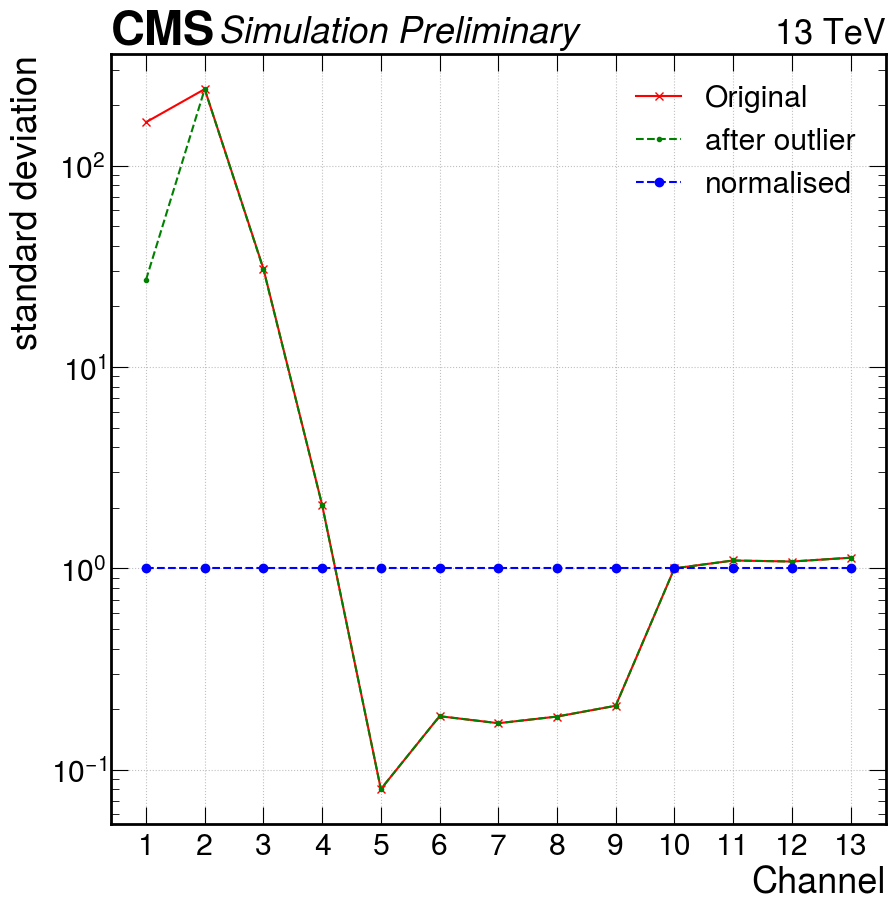

In [72]:

Channels = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# Plotting
fig, ax = plt.subplots()
plt.plot(Channels, orig_std, marker='x',color = 'r',label='Original')
plt.plot(Channels, after_outlier_std, marker='.', linestyle='--', color = 'g',label='after outlier')
plt.plot(Channels, normalised_std, marker='o', linestyle='--', color = 'b',label='normalised')
plt.xlabel('Channel')
plt.xticks(np.arange(1, 14, 1))
plt.ylabel('standard deviation')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
plt.grid(True)
plt.minorticks_off()
plt.legend()
plt.yscale('log')
plt.show()


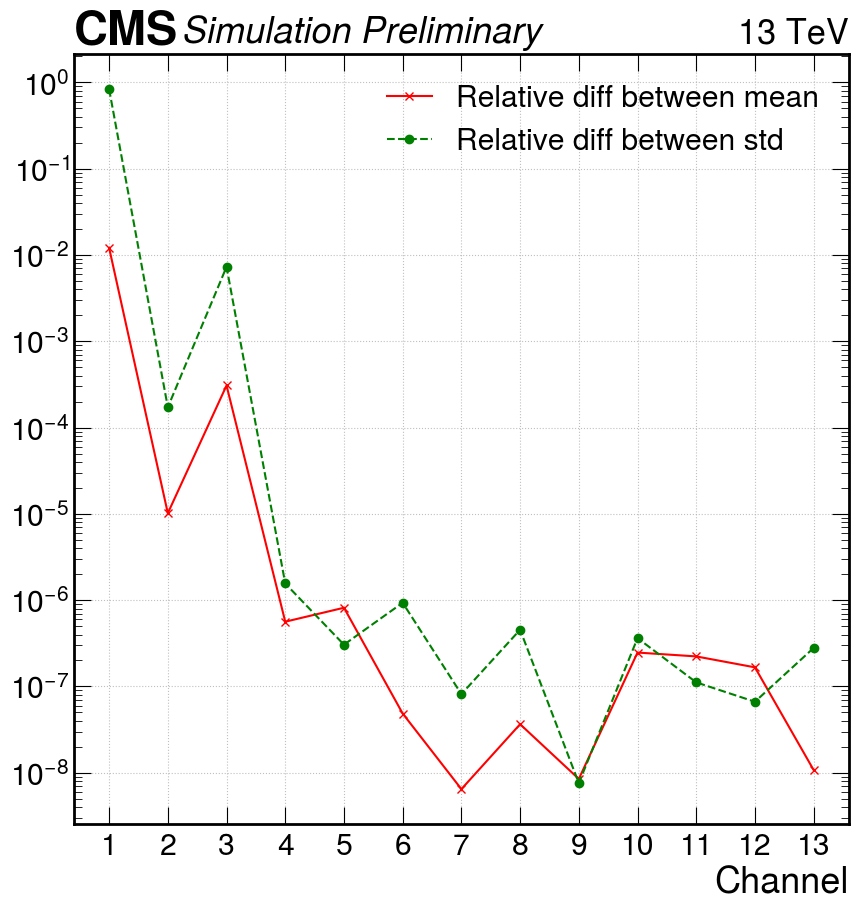

In [71]:
Channels = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# Plotting
fig, ax = plt.subplots()
plt.plot(Channels, np.abs(orig_mean- after_outlier_mean)/orig_mean, marker='x',color = 'r',label='Relative diff between mean')
plt.plot(Channels, np.abs(orig_std- after_outlier_std)/orig_std, marker='o',linestyle='--',color = 'g',label='Relative diff between std')
# plt.plot(Channels, normalised_mean, marker='o', linestyle='--', color = 'b',label='normalised')
plt.xlabel('Channel')
plt.xticks(np.arange(1, 14, 1))
# plt.ylabel('Mean Value')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
plt.grid(True)
plt.minorticks_off()
plt.legend()
plt.yscale('log')
plt.show()
